# **OBTENDO OS DADOS**

## Configuração


In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"


# Common imports
import numpy as np
import pandas as pd
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


## Obtendo os dados

In [ ]:
import os
import requests
import zipfile
import pandas as pd

url = "https://www.kaggle.com/api/v1/datasets/download/joebeachcapital/30000-spotify-songs"
zip_path = "spotify_songs.zip"
extract_path = "./datasets"
#create dataframe songs:


# Faz o download do arquivo zip
response = requests.get(url)
with open(zip_path, "wb") as file:
    file.write(response.content)
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

## Conferindo rapidamente o dataset

In [ ]:
csv_path = os.path.join(extract_path, "spotify_songs.csv")
songs = pd.read_csv(csv_path)
print(songs.head())

                 track_id                                         track_name  \
0  6f807x0ima9a1j3VPbc7VN  I Don't Care (with Justin Bieber) - Loud Luxur...   
1  0r7CVbZTWZgbTCYdfa2P31                    Memories - Dillon Francis Remix   
2  1z1Hg7Vb0AhHDiEmnDE79l                    All the Time - Don Diablo Remix   
3  75FpbthrwQmzHlBJLuGdC7                  Call You Mine - Keanu Silva Remix   
4  1e8PAfcKUYoKkxPhrHqw4x            Someone You Loved - Future Humans Remix   

       track_artist  track_popularity          track_album_id  \
0        Ed Sheeran                66  2oCs0DGTsRO98Gh5ZSl2Cx   
1          Maroon 5                67  63rPSO264uRjW1X5E6cWv6   
2      Zara Larsson                70  1HoSmj2eLcsrR0vE9gThr4   
3  The Chainsmokers                60  1nqYsOef1yKKuGOVchbsk6   
4     Lewis Capaldi                69  7m7vv9wlQ4i0LFuJiE2zsQ   

                                    track_album_name track_album_release_date  \
0  I Don't Care (with Justin Bieber) [Loud Luxu

In [ ]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32833 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32833 non-null  int64  
 4   track_album_id            32833 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32833 non-null  object 
 7   playlist_name             32833 non-null  object 
 8   playlist_id               32833 non-null  object 
 9   playlist_genre            32833 non-null  object 
 10  playlist_subgenre         32833 non-null  object 
 11  danceability              32833 non-null  float64
 12  energy                    32833 non-null  float64
 13  key                       32833 non-null  int64  
 14  loudne

In [ ]:
pd.set_option('display.max_rows', None)
songs["playlist_genre"].value_counts()

,count
playlist_genre,
edm,6043
rap,5746
pop,5507
r&b,5431
latin,5155
rock,4951


# **PREPARANDO OS DADOS**

##Definição das **Funções para tratamento dos dados**.

In [ ]:
# REMOÇÃO DE DUPLICATAS - remove músicas repetidas

def removeDuplicates(df):
    # Adiciona uma coluna auxiliar com o nome da música em lowercase
    df['track_name_lower'] = df['track_name'].str.lower()
    # Remove duplicadas usando a coluna auxiliar
    df_unique = df.drop_duplicates(subset=['track_artist', 'track_name_lower'])
    # Remove a coluna auxiliar antes de retornar
    df_unique = df_unique.drop(columns=['track_name_lower'])
    return df_unique

In [ ]:
# REMOÇÃO DE COLUNAS - Remove colunas não úteis para a predição.

def removeColumns(df, columns_name):
    return df.drop(columns=columns_name)

In [ ]:
# REMOÇÃO DE LINHAS - Remove linhas que possuem dados em branco e que não podem ser obtidos por meio de outros dados.

#Utilizar depois de remover as colunas que não serão necessárias para a predição do modelo.
def removeRowNaN(songs_cp):
    songs_cp_sem_nulos = songs_cp.dropna(axis=0, how='any')
    return songs_cp_sem_nulos

def dropRowsEmpty(songs_cp):
    songs_cp_sem_nulos = removeRowNaN(songs_cp)
    valores_nulos_por_coluna = songs_cp_sem_nulos.isna().sum()
    songs_cp = songs_cp_sem_nulos
    return songs_cp


In [ ]:
# NORMALIZAÇÃO DE DADOS NUMÉRICOS

#Normaliza os dados numa escala de 0 a 1.
def normalizeColumns(df,columns_name):
    scaler = MinMaxScaler()
    df[columns_name] = scaler.fit_transform(df[columns_name])
    return df

In [ ]:
def onehotEncode(df, columns):
    """
    Aplica One-Hot Encoding para colunas categóricas com poucas categorias.

    Parâmetros:
    - df (DataFrame): O DataFrame de entrada.
    - columns (list): Lista de colunas categóricas a serem transformadas.

    Retorna:
    - df (DataFrame): DataFrame atualizado com as colunas one-hot.
    """
    df = pd.get_dummies(df, columns=columns, prefix=columns, drop_first=True)
    return df


In [ ]:
# PREENCHE MẼS DE LANÇAMENTO DAS MÚSICAS QUE NÃO POSSUEM ESSE DADO.

def fillMonths(songs: pd.DataFrame) -> pd.DataFrame:
    # Criar uma cópia do DataFrame para evitar modificar o original
    df = songs.copy()

    # Filtrar as linhas onde a data de lançamento tem apenas o ano (4 caracteres)
    df_ano_apenas = df[df['track_album_release_date'].str.len() == 4].copy()

    # Filtrar as linhas onde a data de lançamento tem o formato completo (ano-mês-dia)
    df_completo = df[df['track_album_release_date'].str.len() == 10].copy()

    # Extrair o mês das músicas com ano-mês-dia
    df_completo['month'] = df_completo['track_album_release_date'].str[5:7]

    # Contar a frequência de cada mês
    month_counts = df_completo['month'].value_counts()

    # Agora vamos preencher os meses nas músicas com ano apenas, de forma proporcional
    # Criação de uma lista que vai armazenar os meses a serem atribuídos
    months_to_fill = []

    # Para cada mês na distribuição, vamos adicionar o mês de forma proporcional
    for month, count in month_counts.items():
        months_to_fill.extend([month] * count)

    # Para as músicas faltando mês, vamos preencher com base na lista 'months_to_fill'
    df_ano_apenas['month'] = np.random.choice(months_to_fill, size=len(df_ano_apenas))

    # Agora vamos juntar os dois DataFrames (completo e preenchido) novamente
    # Garantindo que estamos mantendo todas as colunas, não apenas 'track_album_release_date'
    df_completo['month'] = df_completo['month']  # As músicas já completas não devem ser modificadas
    df_ano_apenas['track_album_release_date'] = df_ano_apenas['track_album_release_date'] + '-' + df_ano_apenas['month'] + '-01'

    # Substituir as linhas no DataFrame copiado
    df.update(df_completo)  # Atualiza as músicas completas
    df.update(df_ano_apenas)  # Atualiza as músicas com ano apenas

    # Retornar o DataFrame alterado
    return df

In [ ]:
# DECOMPÕE A COLUNA 'track_album_release_date' EM 'track_year' E 'track_month'.

def decompositionDateTransform(df, date_column):
    # Como o ano é composto de 4 dígitos, iremos extrair os 4 primeiros caracteres da coluna
    def get_year(date):
        if isinstance(date, str) and len(date) >= 4 and date[:4].isdigit():
            return int(date[:4])
        return None

    # Depois dos 4 caracteres teremos um '-' que faz a divisão do ano e mês, iremos fazer
    # split e pegaremos os dois próximos dígitos
    def get_month(date):
        if isinstance(date, str) and len(date) >= 7:
            parts = date.split('-')
            if len(parts) > 1 and parts[1].isdigit():
                return f"{int(parts[1]):02d}"  # Garantir dois dígitos no mês
        return None

    # Agora adicionamos as novas colunas
    df['track_year'] = df[date_column].apply(get_year)
    df['track_month'] = df[date_column].apply(get_month)
    return df

In [ ]:
# DECOMPÕE 'duration_ms' EM 'track_minutes' E 'track_seconds'.

def MilisecondsTransform(df, millis_column):
    def get_minutes(millis):
        if isinstance(millis, (int, float)) and millis >= 0:
            return millis // 60000
        return None

    def get_seconds(millis):
        if isinstance(millis, (int, float)) and millis >= 0:
            return (millis % 60000) // 1000
        return None

    df['track_minutes'] = df[millis_column].apply(get_minutes)
    df['track_seconds'] = df[millis_column].apply(get_seconds)
    return df

In [ ]:
# CLASSIFICA A COLUNA 'duration_ms' EM 0,1,2,3,4,5 e 6, NA COLUNA 'track_duration_classification'

def classifyDuration(df, millis_column):
    def classify(millis):
        if isinstance(millis, (int, float)) and millis >= 0:
            duration_minutes = millis / 60000
            if duration_minutes == 0:
                return 0
            elif duration_minutes <= 1:
                return 1
            elif duration_minutes <= 2:
                return 2
            elif duration_minutes <= 3:
                return 3
            elif duration_minutes <= 4:
                return 4
            elif duration_minutes <= 5:
                return 5
            else:
                return 6
        return None

    df['track_duration_classification'] = df[millis_column].apply(classify)
    return df

In [ ]:
# RETORNA OS DADOS DISCRETIZADOS E POSSÍVEIS OUTLIERS

def discretizeAndPossibleOutliers(data, n_bins=10, metodo='quantis'):
    if metodo == 'quantis':
        # Discretização baseada em quantis (divide os dados em n_bins intervalos com número igual de dados)
        bins = np.percentile(data, np.linspace(0, 100, n_bins+1))
        labels = [f'Intervalo {i+1}' for i in range(n_bins)]
        data_discretizada = pd.cut(data, bins=bins, labels=labels, include_lowest=True)
    elif metodo == 'igual':
        # Discretização por intervalos iguais (divide os dados em n_bins intervalos de tamanho igual)
        bins = np.linspace(data.min(), data.max(), n_bins+1)
        labels = [f'Intervalo {i+1}' for i in range(n_bins)]
        data_discretizada = pd.cut(data, bins=bins, labels=labels, include_lowest=True)
    else:
        raise ValueError("ERROR: 'quantis' ou 'igual'.")

    # Visualizar os dados discretizados
    sns.histplot(data_discretizada, kde=False, discrete=True, color='skyblue')
    plt.title('Distribuição dos Dados Discretizados')
    plt.xlabel('I')
    plt.ylabel('C')
    plt.show()

    # Identificar outliers (valores fora de 1.5 vezes o intervalo interquartil)
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    outliers = data[(data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))]

    return data_discretizada, outliers

In [ ]:
# ONEHOT do gênero das músicas


def oneHotGenre(df):

  # Aplicar One-Hot Encoding e modificar os nomes das colunas
  one_hot = pd.get_dummies(df['playlist_genre'], prefix='track_genre')

  # Garantir que os valores sejam inteiros (0 ou 1)
  one_hot = one_hot.astype(int)

  # Concatenar o resultado no DataFrame original e remover a coluna original
  df = pd.concat([df, one_hot], axis=1).drop(columns=['playlist_genre'])

  return df


##Definição das **Funções de apoio**.

In [ ]:
# Mostra nível de popularidade por gênero

def popularityPerGenre(songs):
    # Agrupar por 'playlist_genre' e calcular a média da popularidade
    genre_popularity = songs.groupby("playlist_genre")["track_popularity"].mean()
    # Ordenar os resultados em ordem decrescente
    genre_popularity_sorted = genre_popularity.sort_values(ascending=False)
    # Exibir os gêneros com músicas mais populares
    print(genre_popularity_sorted)

In [ ]:
# Retorna todos os artistas e suas respectivas popularidade

def getArtistsAndPopularity(df, alpha=5):
    # Verifica se as colunas necessárias existem no DataFrame
    if 'track_artist' not in df.columns or 'track_popularity' not in df.columns:
        raise ValueError("O dataset deve conter as colunas 'track_artist' e 'track_popularity'.")
    # Calcula a popularidade total por artista
    artist_total_popularity = df.groupby('track_artist')['track_popularity'].sum()
    # Conta o número de músicas por artista
    artist_song_count = df.groupby('track_artist').size()
    # Calcula a popularidade ponderada para cada artista
    artist_weighted_popularity = artist_total_popularity / (artist_song_count + alpha)
    # Ordena os artistas pela popularidade ponderada em ordem decrescente
    artist_weighted_popularity_sorted = artist_weighted_popularity.sort_values(ascending=False)
    # Retorna o DataFrame com o nome do artista e sua popularidade
    return artist_weighted_popularity_sorted.reset_index()

In [ ]:
# Retorna as n musicas mais populares do dataset
def getTopSongs(df,n):
  return df[['track_name', 'track_popularity']].sort_values(by='track_popularity', ascending=False).head(n)

In [ ]:
# Mostra nível de popularidade por gênero

def popularityPerGenre(songs):
    # Agrupar por 'playlist_genre' e calcular a média da popularidade
    genre_popularity = songs.groupby("playlist_genre")["track_popularity"].mean()
    # Ordenar os resultados em ordem decrescente
    genre_popularity_sorted = genre_popularity.sort_values(ascending=False)
    # Exibir os gêneros com músicas mais populares
    print(genre_popularity_sorted)


In [ ]:
def encode_top_artists(df, column='track_artist', threshold=3, known_artists=None):
    """
    Aplica One-Hot Encoding para os artistas mais frequentes e agrupa os outros em 'Other'.

    Parâmetros:
    df (DataFrame) - DataFrame original contendo a coluna dos artistas.
    column (str) - Nome da coluna contendo os artistas.
    threshold (int) - Número mínimo de músicas para um artista ter uma categoria própria.
    known_artists (list) - Lista de artistas conhecidos do conjunto de treino (usada para validação/teste).

    Retorna:
    df_encoded (DataFrame) - DataFrame com One-Hot Encoding aplicado.
    top_artists (list) - Lista de artistas considerados como categorias próprias.
    """
    # Contar quantas músicas cada artista tem no dataset
    artist_counts = df[column].value_counts()

    # Criar lista de artistas que aparecem pelo menos 'threshold' vezes
    top_artists = artist_counts[artist_counts >= threshold].index.tolist()

    # Se estamos processando validação ou teste, usamos os artistas conhecidos do treino
    if known_artists is not None:
        top_artists = known_artists  # Mantemos apenas os que estavam no treino

    # Criar colunas One-Hot apenas para os top artistas
    df_encoded = df.copy()
    for artist in top_artists:
        df_encoded[f"artist_{artist}"] = (df[column] == artist).astype(int)

    # Criar uma coluna "artist_other" para qualquer artista que não esteja na lista
    df_encoded["artist_other"] = df[column].apply(lambda x: 1 if x not in top_artists else 0)

    # Remover a coluna original 'track_artist'
    df_encoded = df_encoded.drop(columns=[column])

    return df_encoded, top_artists


# **PRÉ-PROCESSAMENTO**


## Subfunções

In [ ]:
# Limpeza
def data_cleaning(df):
  #Removendo dados duplicados
  df = removeDuplicates(df)

  #Removendo linhas que possuem dados em branco e que não podem ser obtidos de forma ideal
  df = dropRowsEmpty(df)

  return df


In [ ]:
# Seleção de Características
def feature_selection(df):
  # Dropando colunas que representam id
  df = removeColumns(df,['track_id','track_album_id','playlist_id'])

  # Dropando colunas de nomes que não irão agregar na predição do modelo
  df = removeColumns(df,['track_name','track_album_name','playlist_name', 'playlist_subgenre'])

  return df

In [ ]:
# Engenharia de Atributos
def feature_engeneering(df):
  # Decompõe a coluna 'track_album_release_date' em 'track_year' e 'track_month'
  df = decompositionDateTransform(df,'track_album_release_date')

  # Transforma a coluna 'duration_ms' em 'track_minutes' e 'track_seconds'
  df = MilisecondsTransform(df,'duration_ms')

  # Categoriza as musicas por 'duration_ms' e cria a coluna 'track_duration_classification':
  df = classifyDuration(df,'duration_ms')

  # Realiza oneHot para o gênero das músicas
  df = oneHotGenre(df)

  return df


In [ ]:
# Normalização dos dados
def data_normalize(df):
  # Colocando colunas na mesma escala (normalização)
  normalizeColumns(df,['track_popularity','danceability','energy','key','loudness','mode','speechiness',
                       'acousticness','instrumentalness','liveness','valence','tempo','track_minutes',
                       'track_seconds','track_year','track_month', 'track_duration_classification'])

  # Já que foram aplicadas transformações em 'track_album_release_date' e 'duration_ms' iremos remover essas colunas pois não serão mais necessárias
  df = removeColumns(df,['track_album_release_date','duration_ms', 'track_month'])

  return df


## Função Principal de pré-processamento dos dados

In [ ]:
# Função principal de pré-processamento dos dados
def pipeline_pre_process(df, conjunto):
  if conjunto == 'general':
    df = data_cleaning(df)
  elif conjunto == 'train':
    df = feature_selection(df)
    df = feature_engeneering(df)
    df = data_normalize(df)
  elif conjunto in ['test', 'validation']:
    df = feature_selection(df)
    df = feature_engeneering(df)
    df = data_normalize(df)
  else:
    raise ValueError("ERROR: 'train', 'test' ou 'validation'.")

  return df


## Criando conjuntos de TESTE, TREINO e VALIDAÇÃO.



In [ ]:
#to make this notebook's output identical at every run
np.random.seed(42)

# Aplicando apenas LIMPEZA nos dados gerais, antes de dividir
songs = pipeline_pre_process(songs, 'general')

# 70% treino, 30% temporário (dividido em validação e teste)
train_set, temp_set = train_test_split(songs, test_size=0.3, random_state=42)

# 50% de 30% para validação e 50% para teste (ou seja, 15% validação e 15% teste)
validation_set, test_set = train_test_split(temp_set, test_size=0.5, random_state=42)

# Verificando os tamanhos dos conjuntos
print(f"Tamanho do conjunto de treino: {len(train_set)}")
print(f"Tamanho do conjunto de validação: {len(validation_set)}")
print(f"Tamanho do conjunto de teste: {len(test_set)}")

Tamanho do conjunto de treino: 18312
Tamanho do conjunto de validação: 3924
Tamanho do conjunto de teste: 3924


## Criando uma cópia dos dados para exploração.

In [ ]:
# Cópia do conjunto de treino
train_set_cp = train_set.copy()

# Cópia do conjunto de validação
validation_set_cp = validation_set.copy()

# Cópia do conjunto de teste
test_set_cp = test_set.copy()

## Aplicando pré-processamento nos conjuntos de TREINO, VALIDAÇÃO e TESTE.

In [ ]:
# Aplicar One-Hot Encoding primeiro no treino e capturar os artistas mais frequentes
train_set_cp, reference_artists = encode_top_artists(train_set_cp, column='track_artist', threshold=3)

# Aplicar o mesmo mapeamento na validação e teste, mas permitindo novos artistas em "artist_other"
validation_set_cp, _ = encode_top_artists(validation_set_cp, column='track_artist', threshold=3, known_artists=reference_artists)
test_set_cp, _ = encode_top_artists(test_set_cp, column='track_artist', threshold=3, known_artists=reference_artists)

# Agora podemos fazer o pré-processamento normalmente
train_set_cp = pipeline_pre_process(train_set_cp, 'train')
validation_set_cp = pipeline_pre_process(validation_set_cp, 'validation')
test_set_cp = pipeline_pre_process(test_set_cp, 'test')


A saída de streaming foi truncada nas últimas 5000 linhas.
<ipython-input-117-09a1fb141fae>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_encoded[f"artist_{artist}"] = (df[column] == artist).astype(int)
<ipython-input-117-09a1fb141fae>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_encoded[f"artist_{artist}"] = (df[column] == artist).astype(int)
<ipython-input-117-09a1fb141fae>:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

# **TREINO E AVALIAÇÃO DOS MODELOS**


## Bibliotecas utilizadas

In [ ]:
# Importações necessárias
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.datasets import make_regression
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt

# Xgboost
import xgboost as xgb


# Lightgbm
import lightgbm as lgb

# Ridge
from sklearn.linear_model import Ridge

# Linear Regression
from sklearn.linear_model import LinearRegression

# SVM
from sklearn.svm import SVR



## Funções de apoio

In [ ]:
def split_target_features(df):
    # X_feat: variáveis independentes
    X_feat = df.drop(columns=['track_popularity'], errors='ignore')

    # y_feat: target
    y_feat = df['track_popularity']

    return X_feat, y_feat


In [ ]:
# (FUNÇÃO GERAL) - TREINA O MODELO

def train_model(df, model_name):
    X_train, y_train = split_target_features(df)

    if model_name == 'xgbregressor':
        model = xgb.XGBRegressor()
    elif model_name == 'lightgbm':
        params = {'verbose': -1}
        model = lgb.LGBMRegressor(**params)
    elif model_name == 'ridge':
        model = Ridge()
    elif model_name == 'linear_regression':
        model = LinearRegression()
    elif model_name == 'svm':
        model = SVR(kernel='rbf')  # Pode ajustar para 'linear', 'poly', etc.
    else:
        raise ValueError("Modelo não suportado. Escolha entre 'xgbregressor', 'lightgbm', 'ridge', 'linear_regression' ou 'svm'.")

    # Treinar o modelo
    model.fit(X_train, y_train)

    return model


In [ ]:
# (FUNÇÃO GERAL) - AVALIA E RETORNA A PERFORMANCE DO MODELO

def evaluate_model_performance(df, model):

  X_test, y_test = split_target_features(df)
  y_pred = model.predict(X_test)

  # MAE
  mae = mean_absolute_error(y_test, y_pred)

  # MSE
  mse = mean_squared_error(y_test, y_pred)

  # RMSE
  rmse = np.sqrt(mse)

  # R²
  r2 = r2_score(y_test, y_pred)

  # Exibindo os resultados
  print(f"MAE: {mae}")
  print(f"MSE: {mse}")
  print(f"RMSE: {rmse}")
  print(f"R²: {r2}")
  print("Predições do modelo: ")
  print(y_pred)

In [ ]:
# (FUNÇÃO GERAL) - EXIBE O GRÁFICO DE VALORES REAIS X VALORES PREVISTOS

def plot_predictions(df, model, ax=None):
    X, y_true = split_target_features(df)
    y_pred = model.predict(X)

    if ax is None:
        fig, ax = plt.subplots()  # Cria um novo gráfico se nenhum eixo for passado

    ax.scatter(y_true, y_pred, alpha=0.5)
    ax.set_xlabel("Valores Reais")
    ax.set_ylabel("Valores Preditos")
    ax.set_title("Popularidade das Músicas")
    ax.set_title(f'Predições do {type(model).__name__}')

In [ ]:
# (FUNÇÃO GERAL) - FAZ A VALIDAÇÃO CRUZADA COM 10 FOLDS (Linear Regression e SVM)

def cross_validation(df, model):
    X, y = split_target_features(df)

    if isinstance(model, (LinearRegression, SVR)):  # Verifica se o modelo é de regressão linear ou SVM
        scores = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=10)

        # Calcule o RMSE após a validação cruzada
        rmse_scores = np.sqrt(-scores)  # Convertendo de MSE negativo para RMSE

        print(f"Scores: {rmse_scores}")  # Exibindo os scores (RMSE)
        print(f"Mean RMSE: {rmse_scores.mean()}")  # Média dos RMSEs
        print(f"Standard deviation RMSE: {rmse_scores.std()}")  # Desvio padrão dos RMSEs

    else:
        print("Modelo não suportado. Escolha entre 'linear_regression' ou 'svm'.")


In [ ]:
# (SUBFUNÇÃO) - CALCULA IMPORTÂNCIA DAS VARIÁVEIS (LIGHTGBM)

def feature_importance_lightgbm(df, model):
    # Acessando a importância das características
    importances = model.booster_.feature_importance()

    # Verificando se o número de features no DataFrame é o mesmo que o número de importâncias
    feature_names = model.booster_.feature_name()

    if len(feature_names) != len(importances):
        print("Aviso: O número de features no DataFrame não corresponde ao número de importâncias.")
        return

    # Normalizando as importâncias para a escala de 0-1
    max_importance = max(importances)  # Encontrando o valor máximo de importância
    normalized_importances = [x / max_importance for x in importances]  # Normalizando

    # Criando um DataFrame com as features e suas importâncias normalizadas
    feature_importance = pd.DataFrame({
        'Feature': feature_names,  # As features do modelo
        'Importance': normalized_importances  # Importância normalizada
    })

    # Ordenando da mais importante para a menos importante
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

    return feature_importance

In [ ]:
# (SUBFUNÇÃO) - CALCULA IMPORTÂNCIA DAS VARIÁVEIS (XGB)

def feature_importance_xgb(df, model):
    # Acessando a importância das características
    importances = model.feature_importances_

    # Garantindo que as features utilizadas no modelo sejam as mesmas do DataFrame
    feature_names = df.columns[:len(importances)]  # Pegando as primeiras colunas conforme o número de importâncias

    if len(feature_names) != len(importances):
        print(f"Aviso: O número de features no DataFrame ({len(feature_names)}) não corresponde ao número de importâncias ({len(importances)}).")
        return

    # Normalizando as importâncias para a escala de 0-1
    max_importance = max(importances)  # Encontrando o valor máximo de importância
    normalized_importances = [x / max_importance for x in importances]  # Normalizando

    # Criando um DataFrame com as features e suas importâncias normalizadas
    feature_importance = pd.DataFrame({
        'Feature': feature_names,  # As features do modelo
        'Importance': normalized_importances  # Importância normalizada
    })

    # Ordenando da mais importante para a menos importante
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

    return feature_importance


In [ ]:
# Importância das variáveis - Linear Regression
def feature_importance_linear(df, model):
    X, _ = split_target_features(df)
    importance = np.abs(model.coef_)  # Coeficientes da regressão linear

    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)

    return feature_importance


In [ ]:
# Importância das variáveis - SVM (somente se kernel for linear)
def feature_importance_svm(df, model):
    if model.kernel != 'linear':
        print("Importância de variáveis não disponível para SVM com kernel não-linear.")
        return None

    X, _ = split_target_features(df)
    importance = np.abs(model.coef_.flatten())

    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)

    return feature_importance

In [ ]:
# (SUBFUNÇÃO) - CALCULA IMPORTÂNCIA DAS VARIÁVEIS (RIDGE)

def feature_importance_ridge(df, model):
    X, y = split_target_features(df)
    # Obtendo a importância das variáveis
    importance = np.abs(model.coef_)  # Pegamos o valor absoluto dos coeficientes

    # Criando um DataFrame para visualizar melhor
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importance})

    # Ordenando da mais importante para a menos importante
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

    return feature_importance

In [ ]:
# (FUNÇÃO GERAL) - CALCULA IMPORTÂNCIA DAS VARIÁVEIS

def feature_importance(df, model):
    if model == LinearRegression_model:
        return feature_importance_linear(df, model)
    elif model == SVM_model and SVM_model.kernel == 'linear':
        return feature_importance_svm(df, model)
    else:
        print("Importância de variáveis não disponível para este modelo.")


In [ ]:
# (FUNÇÃO GERAL) - EXIBE GRÁFICO DE DISTRIBUIÇÃO -> VALORES REAIS X VALORES PREVISTOS

def plot_distribution(df, model, ax=None):
    X_true, y_true = split_target_features(df)
    y_pred = model.predict(X_true)

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))  # Cria um novo gráfico se nenhum eixo for passado

    # Plotando os valores reais
    ax.hist(y_true, bins=50, alpha=0.5, label="Valores reais", color='blue', edgecolor='black', log=True)

    # Plotando as predições
    ax.hist(y_pred, bins=50, alpha=0.5, label="Predições", color='orange', edgecolor='black', log=True)

    ax.set_xlabel("Valores")
    ax.set_ylabel("Frequência")
    ax.set_title(f"Distribuição das predições e valores reais: {type(model).__name__}")
    ax.legend(loc="best")

In [ ]:
# (FUNÇÃO GERAL) - EXIBE GRÁFICO DE ERROS

def plot_error(df, model, ax=None):
    X_true, y_true = split_target_features(df)
    y_pred = model.predict(X_true)
    erros = np.array(y_true) - np.array(y_pred)

    # Se 'ax' não for passado, cria um novo eixo
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))  # Define o tamanho do gráfico

    # Plotando o histograma dos erros
    sns.histplot(erros, bins=30, kde=True, ax=ax)  # Agora o gráfico será exibido no eixo 'ax'

    ax.set_xlabel("Erro Residual")  # Nome do eixo X
    ax.set_ylabel("Frequência")  # Nome do eixo Y
    ax.set_title(f"Distribuição dos Erros do Modelo: {type(model).__name__}")  # Título do gráfico


## **Modelo: LightGBM**

### Treino:

In [ ]:
# Treinando modelo com conjunto de treino
LinearRegression_model = train_model(train_set_cp, 'linear_regression')


In [ ]:
# SEM VALIDAÇÃO CRUZADA -> Usando o conjunto de validação
evaluate_model_performance(validation_set_cp, LinearRegression_model)

MAE: 0.17298990453230007
MSE: 0.04621836354402331
RMSE: 0.21498456582746425
R²: 0.19324375567218077
Predições do modelo: 
[0.38432992 0.65057021 0.3413521  ... 0.27363606 0.4378593  0.42269303]


In [ ]:
# COM VALIDAÇÃO CRUZADA -> Usando o conjunto de validação
cross_validation(validation_set_cp, LinearRegression_model)

Scores: [0.22930551 0.23294038 0.22541881 0.22539466 0.23291511 0.2124377
 0.23715061 0.22312817 0.23257751 0.22606354]
Mean RMSE: 0.22773320012747159
Standard deviation RMSE: 0.006613364332340175


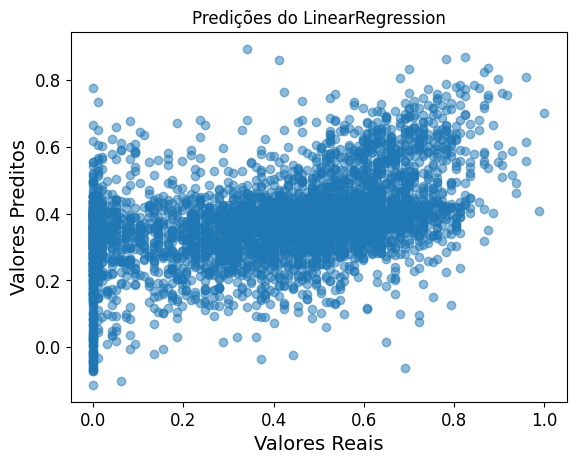

In [ ]:
# Visualizando dados: Previsão X Dados verdadeiros
plot_predictions(validation_set_cp, LinearRegression_model)

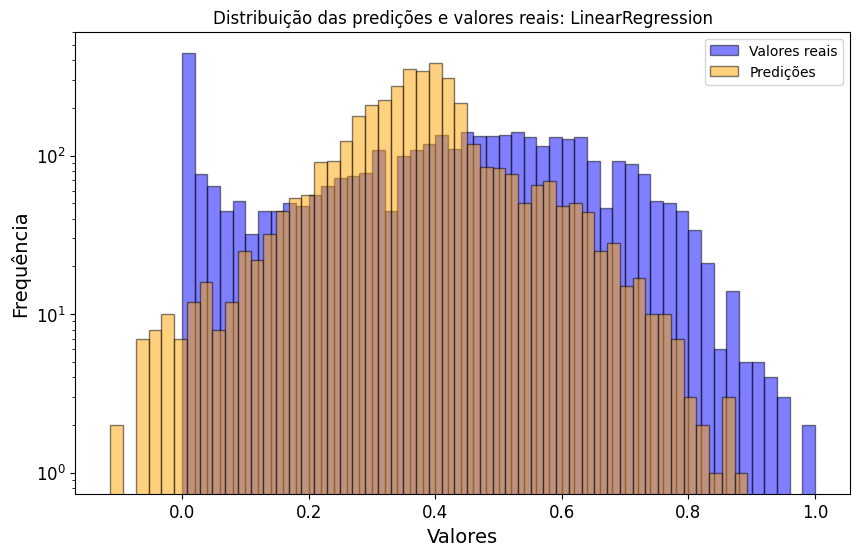

In [ ]:
plot_distribution(validation_set_cp, LinearRegression_model)

In [ ]:
# Importância das variáveis
feature_importance(train_set_cp, LinearRegression_model)

,Feature,Importance
1330,artist_The Years Gone By,0.481029
174,artist_G-Unit,0.475166
649,artist_Jotdog,0.474795
1395,artist_Violent Femmes,0.474537
956,artist_Two Feet,0.473042
761,artist_Blvckross,0.464966
749,artist_Milonair,0.460909
950,artist_Apollo LTD,0.459064
1064,artist_Ghostofblu,0.456365
1478,artist_LEISURE,0.454358


In [ ]:
# Treinando modelo com conjunto de treino
SVM_model = train_model(train_set_cp, 'svm')

In [ ]:
evaluate_model_performance(validation_set_cp, SVM_model)

MAE: 0.16740062950193532
MSE: 0.04422185800854944
RMSE: 0.21028993796315942
R²: 0.22809339516762506
Predições do modelo: 
[0.31987867 0.5923965  0.31151296 ... 0.32979912 0.44421345 0.46163517]


In [ ]:
cross_validation(validation_set_cp, SVM_model)

Scores: [0.21952633 0.21823549 0.21759927 0.2157724  0.22531757 0.20930735
 0.2245183  0.21572479 0.22240016 0.21685724]
Mean RMSE: 0.2185258897736262
Standard deviation RMSE: 0.004496480107123965


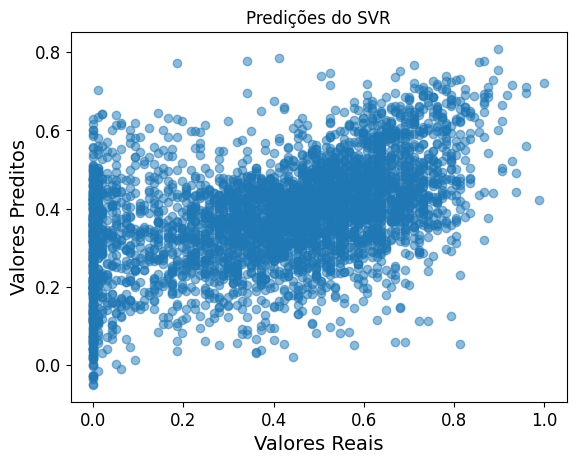

In [ ]:
plot_predictions(validation_set_cp, SVM_model)

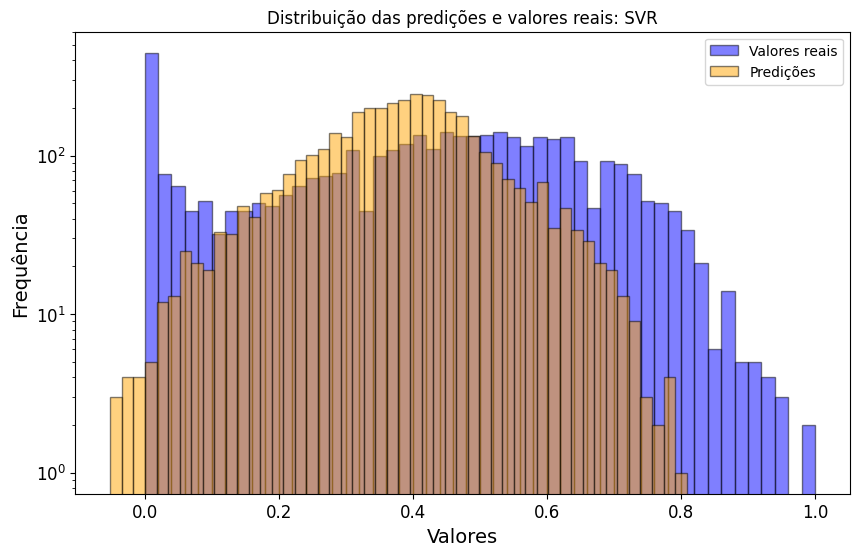

In [ ]:
plot_distribution(validation_set_cp, SVM_model)

In [ ]:
feature_importance(train_set_cp, SVM_model)

Importância de variáveis não disponível para este modelo.


# **ANÁLISE DE ERROS**

In [ ]:
# Criando a figura com 5 colunas para os 5 modelos
fig, axes = plt.subplots(1, 5, figsize=(20, 5))  # 1 linha, 5 gráficos lado a lado

# Chamando a função para cada modelo, passando os eixos correspondentes
plot_predictions(validation_set_cp, LinearRegression_model, ax=axes[3])
plot_predictions(validation_set_cp, SVM_model, ax=axes[4])

plt.tight_layout()
plt.show()

In [ ]:
# Criando a figura com 5 gráficos lado a lado para distribuição de predições
fig, axes = plt.subplots(1, 5, figsize=(22, 6))

# Chamando a função para cada modelo
plot_distribution(validation_set_cp, LinearRegression_model, ax=axes[3])
plot_distribution(validation_set_cp, SVM_model, ax=axes[4])

plt.tight_layout()
plt.show()

#### **(PERGUNTA)** Quais erros os modelos mais cometeram?  


1.  Os modelos XGBRegression, LightGBM e Ridge cometeram erros semelhantes.
2.  Nos pontos extremos(próximos de zero e próximos de 1), os 3 modelos tendem a ser menos precisos.
3.  O XGBRegression foi o modelo com piores resultados, embora ele consiga seguir a tendência geral, há muitos pontos dispersos em relação aos outros dois modelos.
4.  O XGBRegression superetimou os valores de previsão na maioria dos dados.
5.  Já o LightGBM foi melhor que o XGBRegression. Seguiu